# MethylScore output filtering 

In [1]:
# import packages 
import os
import awkward as ak
import shutil
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Put in categories of hyper- and hypomethylated 

In [2]:
# Define the function to perform the renaming
def rename_based_on_condition(item):
    if item.startswith('A'):
        return 'A'  # Rename if the item starts with A
    elif item.startswith('N'):
        return 'N'  # Rename if the item starts with N
    elif item.startswith('2'):
        return 'R'  # Rename if the item starts with 2


def process_input_file(input_file_path):
    # create result df
    result = pd.DataFrame()
    matched_lines = []

    with open(input_file_path, 'r') as file:
        for i,line in enumerate(file):
            if line.strip() == '': 
                continue
            # Split the line into columns
            columns = line.strip().split('\t')

            # Extract the identified clusters column
            clusters = columns[5:-3]
            num_elements = len(clusters)
            half = num_elements // 2
            first_half = clusters[:half]
            last_half = clusters[half:]

            # for last half check put into categories
            last_half = [cluster.split(':')[1] for cluster in last_half]
            last_half = list(map(rename_based_on_condition, last_half))
            
            # for first half 
            first_half = [cluster.split(':')[1] for cluster in first_half]
            # convert lists to dict 
            percentages = {key: [] for key in last_half}
            for condition, percentage in zip(last_half, first_half):
                if percentage == '':
                    continue
                percentages[condition].append(float(percentage))
            percentages = {key: np.mean(value) for key, value in percentages.items()}

            if set(['N','A']) == set(percentages.keys()): 
                ratio = percentages['A'] / percentages['N']
                result.loc[i, 'comparison'] = 'AvsN'
            elif set(['N','R']) == set(percentages.keys()):
                ratio = percentages['R'] / percentages['N']
                result.loc[i, 'comparison'] = 'RvsN'
            elif set(['A','R']) == set(percentages.keys()):
                ratio = percentages['R'] / percentages['A']
                result.loc[i, 'comparison'] = 'RvsA'
            else:
                continue
            result.loc[i, 'chr'] = columns[0]
            result.loc[i, 'start'] = int(columns[1])
            result.loc[i, 'end'] = int(columns[2])
            
            if ratio > 1: 
                result.loc[i, 'methylation_status'] = 'hyper'
            elif ratio < 1: 
                result.loc[i, 'methylation_status'] = 'hypo'                    
            elif ratio == 1: # equal
                result.loc[i, 'methylation_status'] = 'equal'
    result['start'] = result['start'].astype(int)
    result['end'] = result['end'].astype(int)
    return result

# List of input file paths
input_files = ['7_match_dmr_to_gene/dmr_withingene_NvsA.txt', '7_match_dmr_to_gene/dmr_withingene_NvsR.txt', '7_match_dmr_to_gene/dmr_withingene_AvsR.txt']

# Process each input file
results = []
for input_file in input_files:
    results.append(process_input_file(input_file))
results = pd.concat(results)


# 2) Add dmr Information to hyper&hypo df 

In [3]:
# import dmr information to match with hyper and hypo information 
dmr_na = pd.read_csv('7_match_dmr_to_gene/dmr_within_geneborders/dmr_withinGeneBorder_NvsA.csv', sep=',').assign(comparison='AvsN')
dmr_nr = pd.read_csv('7_match_dmr_to_gene/dmr_within_geneborders/dmr_withinGeneBorder_NvsR.csv', sep=',').assign(comparison='RvsN')
dmr_ar = pd.read_csv('7_match_dmr_to_gene/dmr_within_geneborders/dmr_withinGeneBorder_AvsR.csv', sep=',').assign(comparison='RvsA')
#concat
dmr = pd.concat([dmr_na, dmr_nr, dmr_ar])

# set index for both dataframes
results = results.set_index(['chr', 'start', 'end', 'comparison'])
dmr= dmr.set_index(['chr', 'start', 'end', 'comparison'])

# append information to dmr
dmr['methylation_status'] = results.loc[dmr.index, 'methylation_status']
dmr.to_csv('10_hyper_hypo_methylation/methylation_status.csv', sep=',')

In [4]:
# prepare data for plotting 
results = results.reset_index()
results['count'] = 1
results = results.groupby(['comparison', 'methylation_status']).sum()
results.reset_index( inplace=True)

# drop equal values 
results = results.loc[results['methylation_status'] != 'equal']
results

,comparison,methylation_status,chr,start,end,count
1,AvsN,hyper,ccar_ua02ccar_ua15ccar_ua16ccar_ua18ccar_ua18c...,84496900,84498563,7
2,AvsN,hypo,ccar_ua05ccar_ua10ccar_ua15ccar_ub09ccar_ub11c...,85690019,85691665,7
3,RvsA,hyper,ccar_ua18,3682678,3682796,1
4,RvsA,hypo,ccar_ua02ccar_ua05ccar_ua05ccar_ua09ccar_ua13c...,177099188,177102920,14
5,RvsN,hyper,ccar_ua12ccar_ua15ccar_ua15ccar_ua15ccar_ua16c...,79059037,79060808,7
6,RvsN,hypo,ccar_ua02ccar_ua05ccar_ua06ccar_ua11ccar_ua14c...,323769721,323773600,21


# 3) Plot

/tmp/ipykernel_21696/1231957263.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xticklabels=['N to A', 'N to R', 'A to R'])
/tmp/ipykernel_21696/1231957263.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=0)


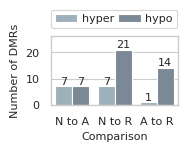

In [5]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)



# create a histogram for each comparison and methylation status 
sns.set_theme(style = 'whitegrid', context='paper', palette=['#99B1BD', '#778899'], rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})
fig, axs = plt.subplots(figsize=((5/2.54), (4.25/2.54)), sharex=True, sharey=True)

ax = sns.barplot(results, x="comparison",order=['AvsN', 'RvsN','RvsA'] ,  y="count", hue="methylation_status", width=0.8)
for container in ax.containers:
    ax.bar_label(container, fontsize=8)
plt.ylabel('Number of DMRs')
plt.ylim(0, 26)
plt.xlabel('Comparison')
#plt.title('Methylation Status of DMRs')
sns.move_legend(ax,  markerscale=0.5, loc='lower right', ncol=3, bbox_to_anchor=(1, 1.1), frameon=True, columnspacing=0.4, scatteryoffsets=[0.6], 
                handletextpad=0.4, borderaxespad=0.1, title='')

ax.set(xticklabels=['N to A', 'N to R', 'A to R'])
wrap_labels(ax,10)
plt.tight_layout()
plt.savefig('10_hyper_hypo_methylation/hyper_hypo_methylation_status.svg')


